# Cabify Data Science Challenge
## by Carlos Nava

### Part 2: Result analysis

#### Background
A ride hailing app currently assigns new incoming trips to the _closest_ available vehicle. To compute such distance, the app currently computes haversine distance between the pickup point and each of the available vehicles. We refer to this distance as *linear* 

However, the expected time to reach A from B in a city is not 100% defined by Haversine distance:
Cities are known to be places where huge amount of transport infrastructure (roads, highways, bridges, tunnels) is deployed to increase capacity and reduce average travel time. Interestingly, this heavy investment in infrastructure also implies that bird distance does not work so well as proxy, so the isochrones for travel time from certain location drastically differ from the perfect circle defined by bird distance, as we can see in this example from CDMX where the blue area represents that it is reachable within a 10 min drive. 

![Imgur](https://i.imgur.com/hYXhpiM.png)
 
In addition to this, travel times can be drastically affected by traffic, accidents, road work...So that even if a driver is only 300m away, he might need to drive for 10 min because of road work in a bridge.

#### Proposal
In order to optimise operations, engineering team has suggested they could query an external real time maps API that not only has roads, but also knows realtime traffic information. We refer to this distance as *road* distance.

In principle this assigment is more efficient and should outperform *linear*. However, the queries to the maps API have a certain cost (per query) and increase the complexity and reliability of a critical system within the company. So Data Science team has designed an experiment to help engineering to decide

#### Experimental design

The designed expirement is very simple. For a period of 5 days, all trips in 3 cities (Bravos, Pentos and Volantis) have been randomly assigned using *linear* or *road* distance:

* Trips whose *trip_id* starts with digits 0-8 were assigned using *road* distance
* Trips whose *trip_id* starts with digits 9-f were assigned using *linear* distance

#### Data description
The collected data is available available in [this link](https://www.dropbox.com/s/e3j1pybfz5o3vq9/intervals_challenge.json.gz?dl=0). Each object represent a `vehicle_interval` that contains the following attributes:

* `type`: can be `going_to_pickup`, `waiting_for_rider` or `driving_to_destination` 
* `trip_id`: uniquely identifies the trip
* `duration`: how long the interval last, in seconds
* `distance`: how far the vehicle moved in this interval, in meters
* `city_id`: either bravos, pentos and volantis
* `started_at`: when the interval started, UTC Time
* `vehicle_id`: uniquely identifies the vehicle
* `rider_id`: uniquely identifies the rider

#### Example
```
{
  "duration": 857,
  "distance": 5384,
  "started_at": 1475499600.287,
  "trip_id": "c00cee6963e0dc66e50e271239426914",
  "vehicle_id": "52d38cf1a3240d5cbdcf730f2d9a47d6",
  "city_id": "pentos",
  "type": "driving_to_destination"
}
```

#### Challenge
Try to answer the following questions

1. Should the company move towards *road* distance? What's the max price it would make sense to pay per query? (make all the  assumptions you need, and make them explicit)
2. How would you improve the experimental design? Would you collect any additional data?

### PART 2

At the end of Part One, the statistical tests to chack if the distributions were normal or have the same distribution failed. Therefore an empirical distribution should be calculated. Also, from the Data Visualization it can be seen that the linear and road dataframes have the same cumulative distribution with minor variations.

### NOTE:
The following assumption is made: Both the linear and road samples have the same empirical distribution but the parameter estimation and kernel density are outside the scope of this work. Therefore a paired t-test will be conducted under the assumption that the theoretical distributions are the same and the sample mean for both of them is close to normally distributed.

#### 4) Paired T-test

Continuing the analysis of the data, the necesary libraries are loaded.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels as sm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
sns.set_context('poster')

In [27]:
statsmodels.test()

Running pytest /home/canf/.local/lib/python3.6/site-packages/statsmodels --tb=short --disable-pytest-warnings
======================================================= test session starts ========================================================
platform linux -- Python 3.6.8, pytest-3.3.2, py-1.5.2, pluggy-0.6.0
rootdir: /home/canf/.local/lib/python3.6/site-packages/statsmodels, inifile: setup.cfg


/home/canf/.local/lib/python3.6/site-packages/statsmodels/conftest.py:55: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/lib/python3/dist-packages/zmq/eventloop/ioloop.py", line 177,

collected 7724 items / 3 errors

============================================================== ERRORS ==============================================================
____________________________________________ ERROR collecting genmod/tests/test_glm.py _____________________________________________
../../.local/lib/python3.6/site-packages/statsmodels/genmod/tests/test_glm.py:1894: in <module>
    @pytest.mark.filterwarnings("ignore:GLM ridge optimization")
/usr/lib/python3/dist-packages/_pytest/mark.py:292: in __getattr__
    self._check(name)
/usr/lib/python3/dist-packages/_pytest/mark.py:308: in _check
    raise AttributeError("%r not a registered marker" % (name,))
E   AttributeError: 'filterwarnings' not a registered marker
_______________________________________ ERROR collecting tsa/vector_ar/tests/test_dynamic.py _______________________________________
../../.local/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/tests/test_dynamic.py:44: in <module>
    @pytest.mark.filterwa

In [28]:
sns.set(font_scale=0.75)

##### 4.1) Loading the data

The data from Part 1 is loaded using the CSV format. 

In [29]:
aux_data = pd.read_csv("aux_data.csv")
aux_data_linear = pd.read_csv("aux_data_linear.csv")
aux_data_road = pd.read_csv("aux_data_road.csv")

##### 4.2) Paired T-test 

The test is performed in the speed variable. The categories are compared using a t-test with different variance.

In [30]:
cat1 = aux_data_linear['speed']
cat2 = aux_data_road['speed']

t_test, p_value = st.ttest_ind(cat1, cat2, equal_var=False)
print('T-test: ', t_test)
print('P-value: ', p_value)

T-test:  -2.213793168149288
P-value:  0.026847646601390853


The p-value suggests that is statistical significat the change between using the road algorithm instead of the linear algorithm. But the Confidence Interval must be calculated to measure the impact of this change.

In [31]:
cm = sm.stats.weightstats.CompareMeans(sm.stats.weightstats.DescrStatsW(cat1),\
        sm.stats.weightstats.DescrStatsW(cat2))
print('Confidence Interval: ', cm.tconfint_diff(usevar='unequal'))

Confidence Interval:  (-0.06900496594192285, -0.004195714187418369)


### Result:

From the t-test and the confidence interval, it can be said that the improvement of the speed is statistically significat but not by much according to the Confidence Interval.

##### 4.3) Testing by City

The samples are splitted by city: pentos, bravos and volantis. Each one is plotted using histograms, scatter points. Also tested using the stated assumption and different variance.

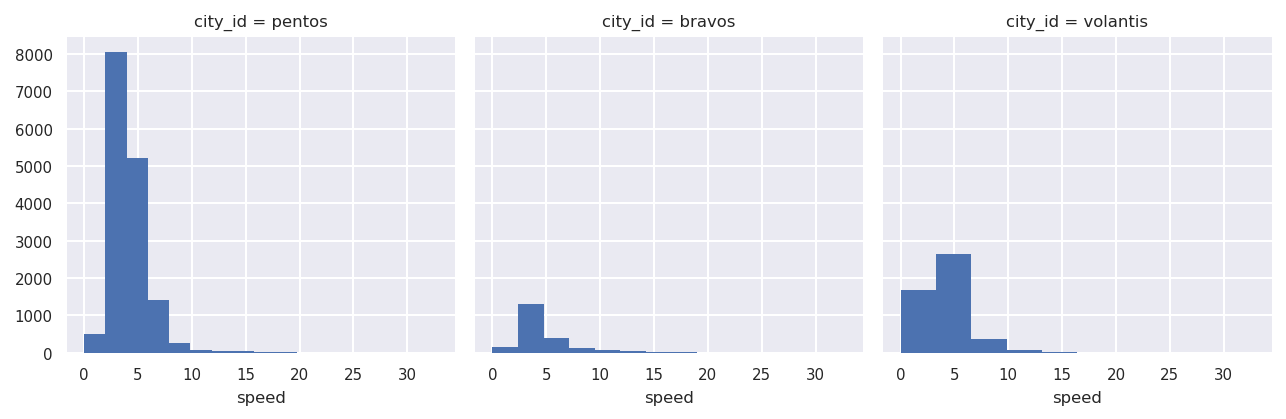

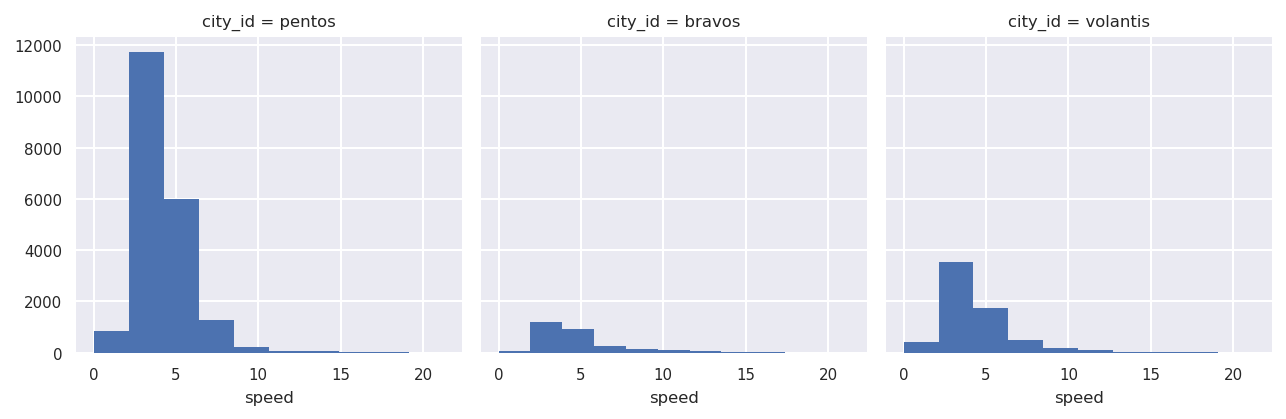

In [32]:
g1 = sns.FacetGrid(aux_data_linear, col="city_id")
g2 = sns.FacetGrid(aux_data_road, col="city_id")
g1.map(plt.hist, 'speed')
g2.map(plt.hist, 'speed')
plt.show()

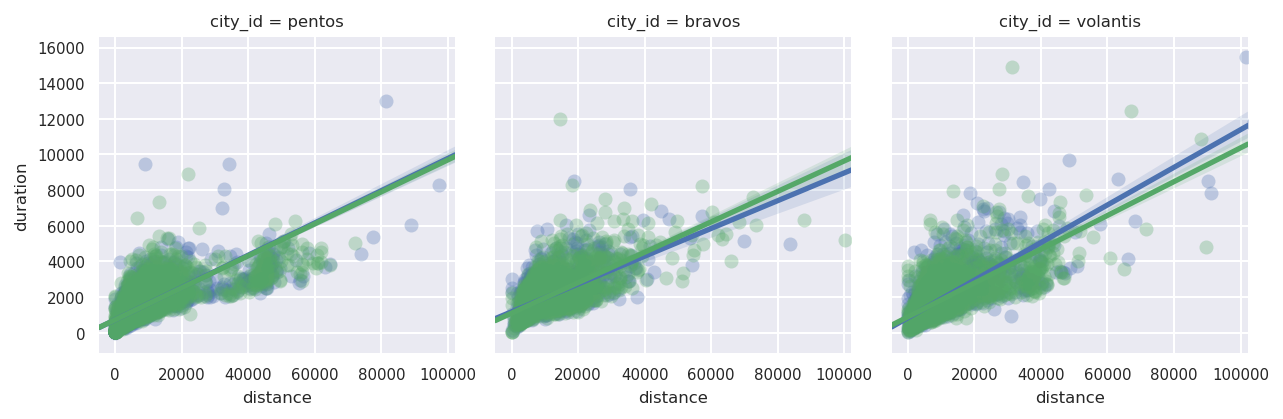

In [33]:
g = sns.FacetGrid(aux_data, col="city_id", hue="trip_cat")
g.map(sns.regplot, "distance", "duration",scatter_kws={'alpha':0.3})
plt.show()

In [34]:
cat1_pentos = aux_data_linear[aux_data_linear['city_id'] == 'pentos']
cat2_pentos = aux_data_road[aux_data_road['city_id'] == 'pentos']

cat1_pentos = cat1_pentos['speed']
cat2_pentos = cat2_pentos['speed']

t_test, p_value = st.ttest_ind(cat1_pentos, cat2_pentos, equal_var=False)
print('T-test: ', t_test)
print('P-value: ', p_value)

T-test:  -0.7779894367638863
P-value:  0.4365807915476292


In [35]:
cm = sm.stats.weightstats.CompareMeans(\
    sm.stats.weightstats.DescrStatsW(cat1_pentos),\
    sm.stats.weightstats.DescrStatsW(cat2_pentos))
print('Confidence Interval: ', cm.tconfint_diff(usevar='unequal'))

Confidence Interval:  (-0.049793128540522105, 0.02149643402947156)


In [36]:
cat1_volantis = aux_data_linear[aux_data_linear['city_id'] == 'volantis']
cat2_volantis = aux_data_road[aux_data_road['city_id'] == 'volantis']

cat1_volantis = cat1_volantis['speed']
cat2_volantis = cat2_volantis['speed']

t_test, p_value = st.ttest_ind(cat1_volantis, cat2_volantis, equal_var=False)
print('T-test: ', t_test)
print('P-value: ', p_value)

T-test:  -2.143551060913481
P-value:  0.03209157210809447


In [37]:
cm = sm.stats.weightstats.CompareMeans(\
    sm.stats.weightstats.DescrStatsW(cat1_volantis),\
    sm.stats.weightstats.DescrStatsW(cat2_volantis))
print('Confidence Interval: ', cm.tconfint_diff(usevar='unequal'))

Confidence Interval:  (-0.1602604858038368, -0.007160754930446406)


In [38]:
cat1_bravos = aux_data_linear[aux_data_linear['city_id'] == 'bravos']
cat2_bravos = aux_data_road[aux_data_road['city_id'] == 'bravos']

cat1_bravos = cat1_bravos['speed']
cat2_bravos = cat2_bravos['speed']

t_test, p_value = st.ttest_ind(cat1_bravos, cat2_bravos, equal_var=False)
print('T-test: ', t_test)
print('P-value: ', p_value)

T-test:  -1.175502204517715
P-value:  0.23985583752157408


In [39]:
cm = sm.stats.weightstats.CompareMeans(\
    sm.stats.weightstats.DescrStatsW(cat1_bravos),\
    sm.stats.weightstats.DescrStatsW(cat2_bravos))
print('Confidence Interval: ', cm.tconfint_diff(usevar='unequal'))

Confidence Interval:  (-0.21903897476175227, 0.05482884979200864)


### Result:

From the experiments it can be said that volantis is where the improvement of the algorithm have a t-test with significance but also with a minor improvement according to the confidence interval.

##### 4.4) Day, Time of the Day and Hour

The samples are splitted by day of the week: Monday and Tuesday; hour of the day and time of the day. Each one is plotted using box plots and scatter points. Also tested using the stated assumption and different variance.

/usr/lib/python3/dist-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


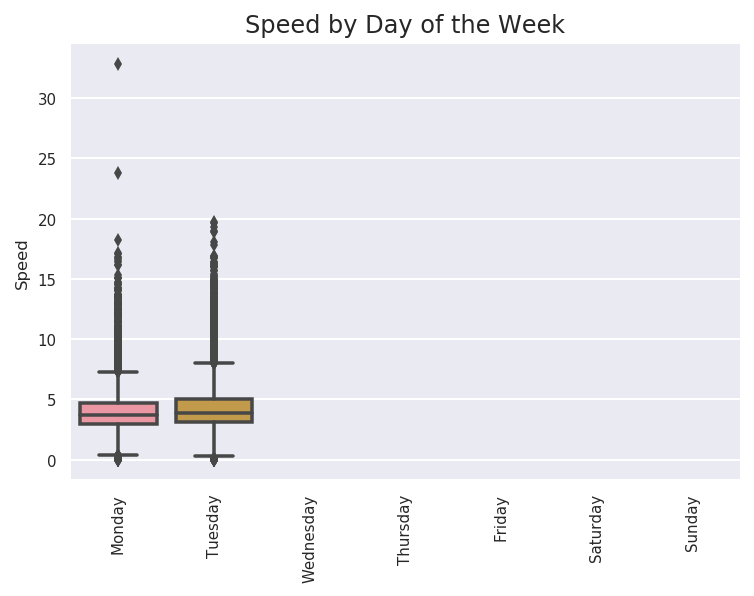

In [40]:
order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='day_name_name', y='speed', data=aux_data_linear, order=order)
plt.title('Speed by Day of the Week', fontsize=12)
plt.xlabel('')
plt.ylabel('Speed')
plt.xticks(rotation=90)
plt.show()

/usr/lib/python3/dist-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


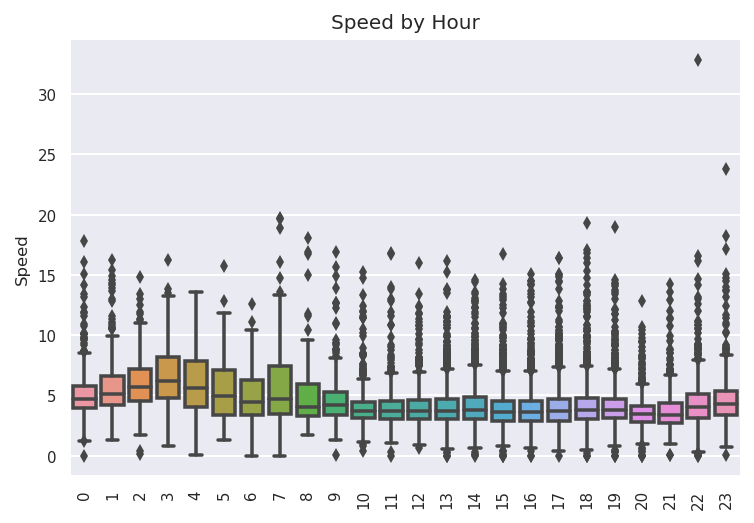

In [41]:
order=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
sns.boxplot(x='hour', y='speed', data=aux_data_linear, order=order)
plt.title('Speed by Hour', fontsize=10)
plt.xlabel('')
plt.ylabel('Speed')
plt.xticks(rotation=90)
plt.show()

/usr/lib/python3/dist-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


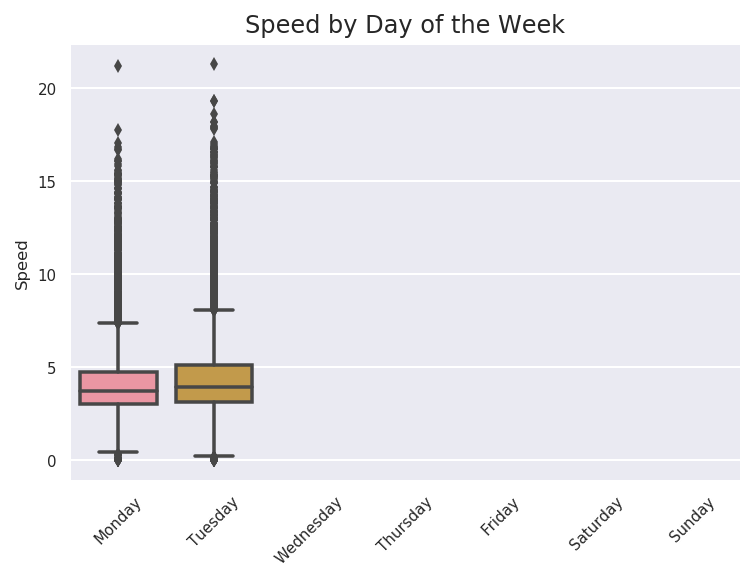

In [42]:
order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='day_name_name', y='speed', data=aux_data_road, order=order)
plt.title('Speed by Day of the Week', fontsize=12)
plt.xlabel('')
plt.ylabel('Speed')
plt.xticks(rotation=45)
plt.show()

/usr/lib/python3/dist-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


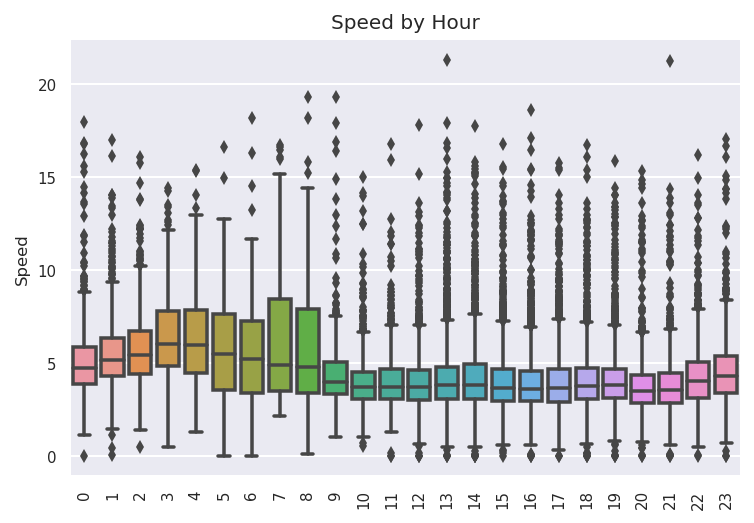

In [43]:
order=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
sns.boxplot(x='hour', y='speed', data=aux_data_road, order=order)
plt.title('Speed by Hour', fontsize=10)
plt.xlabel('')
plt.ylabel('Speed')
plt.xticks(rotation=90)
plt.show()

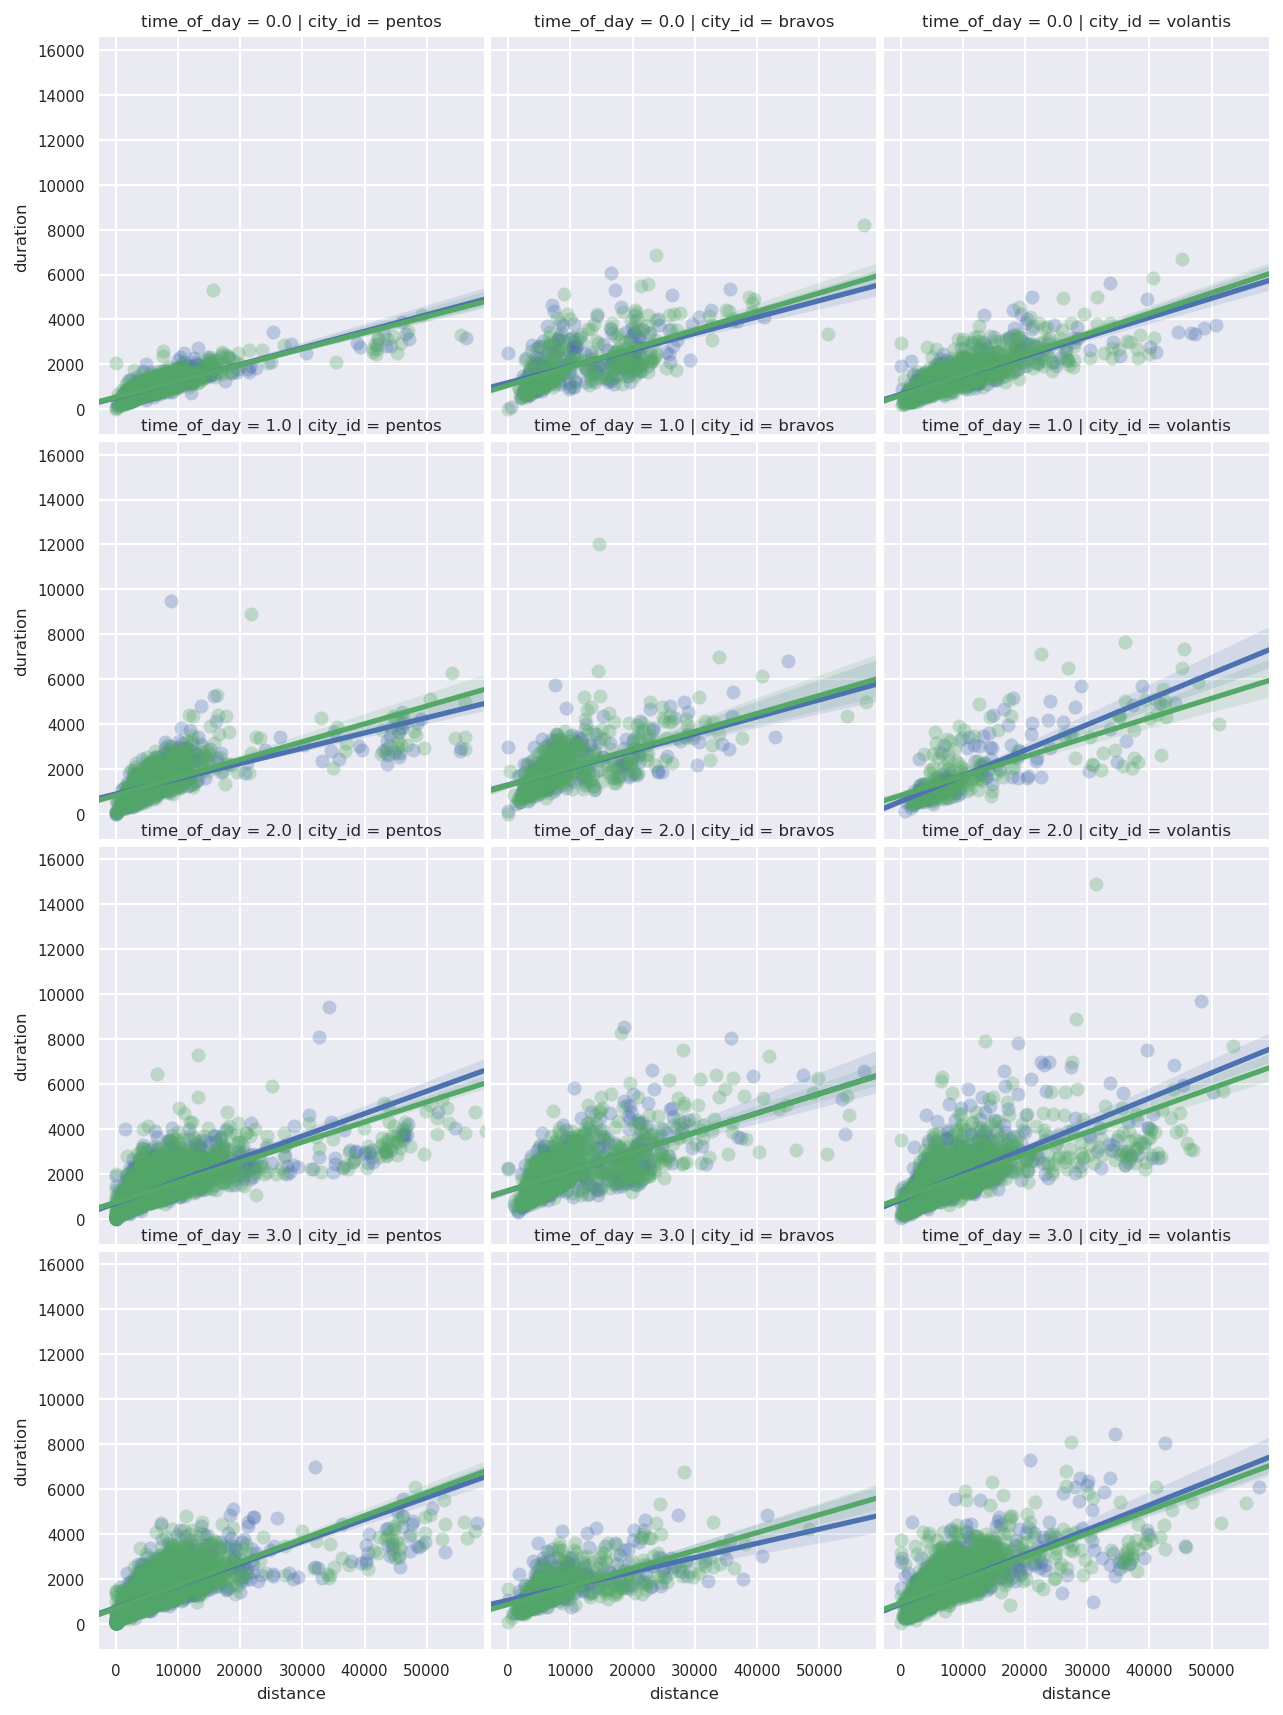

In [44]:
g = sns.FacetGrid(aux_data, row="time_of_day", col="city_id", hue="trip_cat")
g.map(sns.regplot, "distance", "duration",scatter_kws={'alpha':0.3})
g.fig.subplots_adjust(wspace=.02, hspace=.02)

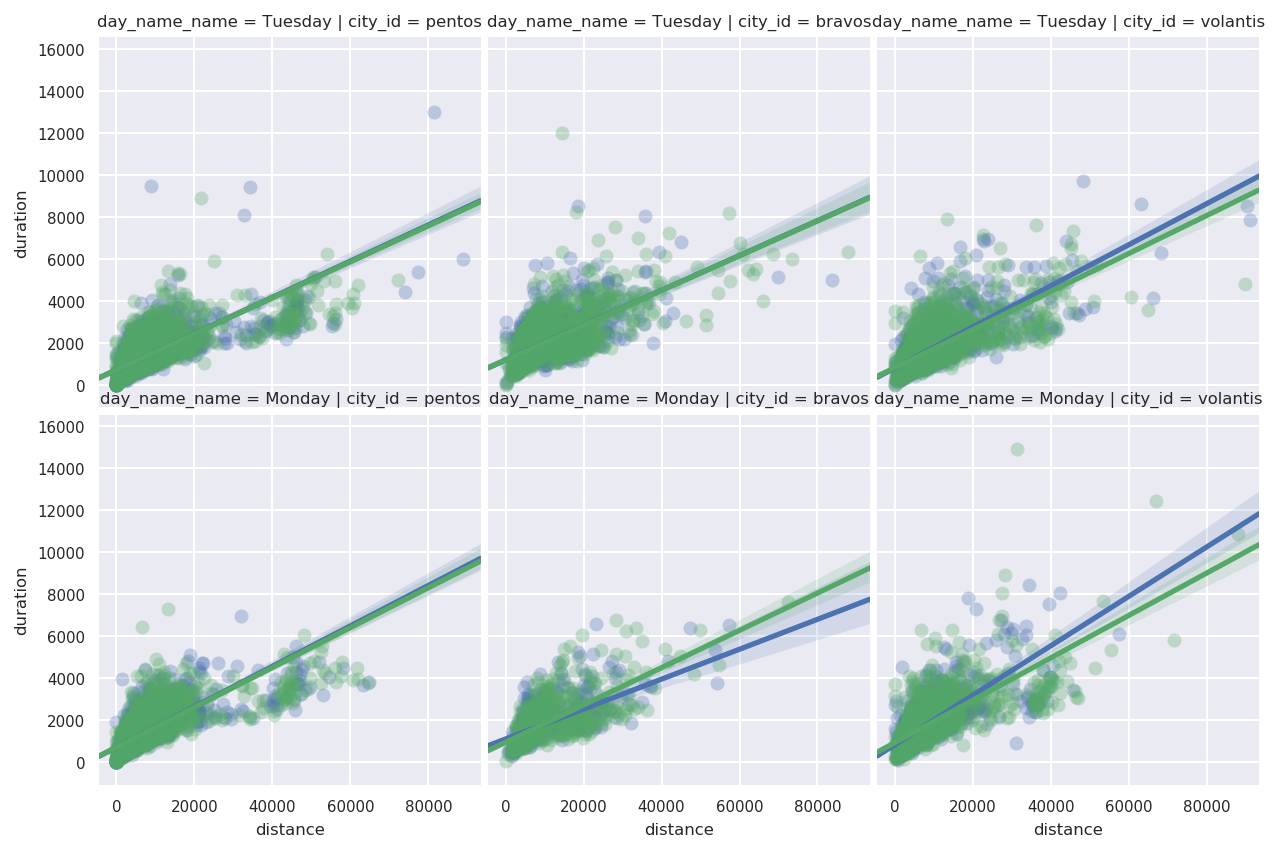

In [45]:
g1 = sns.FacetGrid(aux_data, row="day_name_name", col="city_id", hue="trip_cat")
g1.map(sns.regplot, "distance", "duration",scatter_kws={'alpha':0.3})
g1.fig.subplots_adjust(wspace=.02, hspace=.02)

From the plots it can be seen that volantis during the afternon the algorithm has a better performance and will be tested. The same ocurrs on Monday.

In [46]:
cat1_volantis = aux_data_linear[aux_data_linear['city_id'] == 'volantis']
cat2_volantis = aux_data_road[aux_data_road['city_id'] == 'volantis']

cat1_volantis_noon = cat1_volantis[cat1_volantis['time_of_day'] == 2]
cat2_volantis_noon = cat2_volantis[cat2_volantis['time_of_day'] == 2]

cat1_volantis_noon_speed = cat1_volantis_noon['speed']
cat2_volantis_noon_speed = cat2_volantis_noon['speed']

t_test, p_value = st.ttest_ind(cat1_volantis_noon_speed, cat2_volantis_noon_speed, equal_var=False)
print('T-test: ', t_test)
print('P-value: ', p_value)

T-test:  -2.2164770886909473
P-value:  0.026704127427805865


In [47]:
cm = sm.stats.weightstats.CompareMeans(\
    sm.stats.weightstats.DescrStatsW(cat1_volantis_noon_speed),\
    sm.stats.weightstats.DescrStatsW(cat2_volantis_noon_speed))
print('Confidence Interval: ', cm.tconfint_diff(usevar='unequal'))

Confidence Interval:  (-0.21222192288121608, -0.013008626884645907)


In [48]:
cat1_volantis = aux_data_linear[aux_data_linear['city_id'] == 'volantis']
cat2_volantis = aux_data_road[aux_data_road['city_id'] == 'volantis']

cat1_volantis_monday = cat1_volantis[cat1_volantis['day_name_name'] == 'Monday']
cat2_volantis_monday = cat2_volantis[cat2_volantis['day_name_name'] == 'Monday']

cat1_volantis_monday_speed = cat1_volantis_monday['speed']
cat2_volantis_monday_speed = cat2_volantis_monday['speed']

t_test, p_value = st.ttest_ind(cat1_volantis_monday_speed, cat2_volantis_monday_speed, equal_var=False)
print('T-test: ', t_test)
print('P-value: ', p_value)

T-test:  -1.6818356464766906
P-value:  0.09266076587991236


Finally, Pentos during afternoon also seems to perform well and should be tested.

In [49]:
cat1_pentos = aux_data_linear[aux_data_linear['city_id'] == 'pentos']
cat2_pentos = aux_data_road[aux_data_road['city_id'] == 'pentos']

cat1_pentos_morning = cat1_pentos[cat1_pentos['time_of_day'] == 2]
cat2_pentos_morning = cat2_pentos[cat2_pentos['time_of_day'] == 2]

cat1_pentos_morning_speed = cat1_pentos_morning['speed']
cat2_pentos_morning_speed = cat2_pentos_morning['speed']

t_test, p_value = st.ttest_ind(cat1_pentos_morning_speed, cat2_pentos_morning_speed, equal_var=False)
print('T-test: ', t_test)
print('P-value: ', p_value)

T-test:  -1.6197085734669678
P-value:  0.10531443601796953


### Questions and Answers:

1) Should the company move towards *road* distance? What's the max price it would make sense to pay per query? (make all the  assumptions you need, and make them explicit)

The company should consider using the road algorithm on certain cities and during certain periods of time in which they perform better than the linear algorithms. This analysis support the use of the algorithm on Volantis City during noon and MOndays.
The max price should not be considered given the confidenc interval, which is small to be considered a feature which the user should pay. Therefore it is not adviced to charge for this feature until more conditions are known. For example, if the algorithm performs better on Fridays, on weekends, during holidays or trips with a distance greater than 5 kilometers. This cannot be responded with this sample.

2) How would you improve the experimental design? Would you collect any additional data?

First, I will cover the assumption by determining the empirical distribution of the sample and corroborate if the mean of the samples obey the central limit theorem to use the t-test.

The experiment should be improved by increasing the number of days and months. In this way the travel distance and duration during weekdays and weekends should be captured. Also, the difference between seasonal events during the year can be seen, such as summer and winter holidays.

Other type of cities should also be considered but more date should be used such as population density or geographic extension to assess if the algorithm should be implemented in major cities, large towns or only metropolitan areas.
